# Perform Set up to compare images

In [1]:
import numpy as numpy
from matplotlib import pyplot as matplot
%matplotlib inline
import pandas as pandas
import math
from sklearn import preprocessing
from sklearn import svm
import cv2
import os
import ntpath
from sklearn.metrics.pairwise import cosine_similarity
import fnmatch
import math
from math import sqrt,log
from cmath import sqrt
import glob
import scipy as scipy

data = []
GFile = []
TFile = []
Person = []
angles = []
Len = []
Rho = []
Testdata = []
output = []
similarity = []



def crop_image(img,tol=0):
    mask = img>tol
    return img[numpy.ix_(mask.any(1),mask.any(0))]
def thinning(img):
    #img = cropimage
    size = numpy.size(img)
    skel = numpy.zeros(img.shape,numpy.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

  #  plt.imshow(skel,'gray')
   # plt.show()
    return skel
def coords(thinnedimage):
    rows,cols=thinnedimage.shape
    img_topleft=thinnedimage[0:int(rows/2),0:int(cols/2)]
    img_topright=thinnedimage[int(rows/2)+1:rows,0:int(cols/2)]
    img_bottomleft=thinnedimage[0:int(rows/2),int(cols/2)+1:cols]
    img_bottomright=thinnedimage[int(rows/2)+1:rows,int(cols/2)+1:cols]
    
    topleft_x,topleft_y=COG(img_topleft)
    topright_x,topright_y=COG(img_topright)
    bottomleft_x,bottomleft_y=COG(img_bottomleft)
    bottomright_x,bottomright_y=COG(img_bottomright)

    return topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y

def COG(img):
    x_cor=0
    xrun_sum=0
    y_cor=0
    yrun_sum=0
    #print(img.shape)
    for i in range(img.shape[0]):
        x_cor+=sum(img[i])*i/255
        xrun_sum+=sum(img[i])/255

    for i in range(img.shape[1]):
        y_cor+=sum(img[:,i])*i/255
        yrun_sum+=sum(img[:,i])/255
        #print(img.shape[1]) 
        if yrun_sum==0:
            x_pos=0
        else:
            x_pos=y_cor/(yrun_sum)
        if xrun_sum==0:
            y_pos=0
        else:
            y_pos=x_cor/(xrun_sum)
        
   # print(x_pos)
  #  print(y_pos)
    
    return (x_pos/img.shape[1],y_pos/img.shape[0])

def tan_i(x):
    #print(x)
    if x[0]==0:
        return 90
    return math.degrees(math.atan(x[1]/x[0]))

def tan(thinnedimage):
    rows,cols=thinnedimage.shape
    
    img_tl1=thinnedimage[0:int(rows/2),0:int(cols/4)]
    img_tl2=thinnedimage[0:int(rows/2),int(cols/4)+1:int(cols/2)]
    
    img_tr1=thinnedimage[0:int(rows/2),int(cols/2)+1:int(0.75*cols)]
    img_tr2=thinnedimage[0:int(rows/2),int(0.75*cols)+1:cols]
    
    img_bl1=thinnedimage[int(rows/2)+1:rows,0:int(cols/4)]
    img_bl2=thinnedimage[int(rows/2)+1:rows,int(cols/4)+1:int(cols/2)]
    
    img_br1=thinnedimage[int(rows/2)+1:rows,int(cols/2)+1:int(0.75*cols)]
    img_br2=thinnedimage[int(rows/2)+1:rows,int(0.75*cols)+1:cols]
    

    #plt.imshow(timg,'gray')
    #plt.show()
    
    tl1=tan_i(COG(img_tl1))
    tl2=tan_i(COG(img_tl2))
    tr1=tan_i(COG(img_tr1))
    tr2=tan_i(COG(img_tr2))
    bl1=tan_i(COG(img_bl1))
    bl2=tan_i(COG(img_bl2))
    br1=tan_i(COG(img_br1))
    br2=tan_i(COG(img_br2))
    
    #plt.imshow(img_br1,'gray')
    #plt.show()
    #print(COG(img_br1))
    return tl1,tl2,tr1,tr2,bl1,bl2,br1,br2

def leng_rho(img):
    kernel = numpy.ones((2,2), numpy.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=2)
    img_erosion = cv2.erode(img, kernel, iterations=4)
    edges = cv2.Canny(img_erosion,cv2.THRESH_BINARY+cv2.THRESH_OTSU,550,apertureSize = 3)
    minLineLength=100
    maxLineGap=10
    threshold=20
    image=edges
    lines = cv2.HoughLinesP(image=img,rho=1,theta=numpy.pi/180, threshold=threshold,lines=numpy.array([]), minLineLength=minLineLength,maxLineGap=maxLineGap)
    for x1,y1,x2,y2 in lines[0]:
        theta = math.atan(float(y2 - y1) / (x2 - x1))
        Leng = sqrt((x2-x1)^2 + (y2-y1)^2)
        Rho = (x1 * y2 - x2 * y1) / Leng
        angles.append({'theta': theta, 'p1': (x1, y1), 'p2': (x2, y2)})
    #for i in range(len(angles)):
     #   for j in range(i + 1, len(angles)):
      #      delta = abs(angles[i]['theta'] - angles[j]['theta'])               
    a,b,c = lines.shape
    theta = round(theta,4)
    Rho = round(abs(Rho),0)
    Leng = round(abs(Leng),0)
    return a,b,c,theta,Rho,Leng

def createfingerprint_Genuine(image,GF):
    numpy.seterr(divide='ignore', invalid='ignore')
    aspect_ratio = 1.0*(image.shape[1]/image.shape[0])
    ret,thresh1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(image,127,255,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO_INV)
    a,b,c,theta,Rho,Leng = leng_rho(image)
    blur = cv2.GaussianBlur(thresh1,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image=numpy.invert(th3)
    
    cropimage=crop_image(image,tol=0)
    area=cv2.countNonZero(cropimage)
    area=cv2.countNonZero(cropimage)/(cropimage.shape[0]*cropimage.shape[1])

    img1=numpy.invert(cropimage)
    connectcomp=cv2.connectedComponents(img1)[0]

    thinnedimage=thinning(cropimage)
    
    topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y=coords(thinnedimage)
    tan_topleft_x, tan_topleft_y, tan_topright_x, tan_topright_y, tan_bottomleft_x, tan_bottomleft_y, tan_bottomright_x, tan_bottomright_y = tan(thinnedimage)
    
      
    a=pandas.Series([GF,area,connectcomp,topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y,tan_topleft_x, tan_topleft_y, tan_topright_x, tan_topright_y, tan_bottomleft_x, tan_bottomleft_y, tan_bottomright_x, tan_bottomright_y,aspect_ratio, a,b,c,theta,Rho,Leng],index=
                    ["File_Name","Norm_area","connected_comps","topleft_x","topleft_y","topright_x","topright_y","bottomleft_x","bottomleft_y","bottomright_x","bottomright_y","tan_topleft_x", "tan_topleft_y", "tan_topright_x", "tan_topright_y", "tan_bottomleft_x", "tan_bottomleft_y", "tan_bottomright_x", "tan_bottomright_y","Aspect_Ratio","a","b","c","theta","Rho","Leng"])
    data.append(a)

def createfingerprint_Test(image,TF):
    numpy.seterr(divide='ignore', invalid='ignore')
    aspect_ratio = 1.0*(image.shape[1]/image.shape[0])
    ret,thresh1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(image,127,255,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO_INV)
    a,b,c,theta,Rho,Leng = leng_rho(image)
    blur = cv2.GaussianBlur(thresh1,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image=numpy.invert(th3)
    
    cropimage=crop_image(image,tol=0)
    area=cv2.countNonZero(cropimage)
    area=cv2.countNonZero(cropimage)/(cropimage.shape[0]*cropimage.shape[1])

    img1=numpy.invert(cropimage)
    connectcomp=cv2.connectedComponents(img1)[0]

    thinnedimage=thinning(cropimage)
    #Thinning the image!

    topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y=coords(thinnedimage)
    tan_topleft_x, tan_topleft_y, tan_topright_x, tan_topright_y, tan_bottomleft_x, tan_bottomleft_y, tan_bottomright_x, tan_bottomright_y = tan(thinnedimage)
    
        #Extracting features

    b=pandas.Series([TF,area,connectcomp,topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y,tan_topleft_x, tan_topleft_y, tan_topright_x, tan_topright_y, tan_bottomleft_x, tan_bottomleft_y, tan_bottomright_x, tan_bottomright_y,aspect_ratio,a,b,c,theta,Rho,Leng],index=
                    ["File_Name","Norm_area","connected_comps","topleft_x","topleft_y","topright_x","topright_y","bottomleft_x","bottomleft_y","bottomright_x","bottomright_y","tan_topleft_x", "tan_topleft_y", "tan_topright_x", "tan_topright_y", "tan_bottomleft_x", "tan_bottomleft_y", "tan_bottomright_x", "tan_bottomright_y","Aspect_Ratio","a","b","c","theta","Rho","Leng"])
    Testdata.append(b)
    
def create_training_Genuine_dataset(GF):
    numpy.seterr(divide='ignore', invalid='ignore')
    os.chdir(Genuinedir)
    path = glob.glob(Genuinedir+str(GF))[0]
    image = cv2.imread(path,0)
    createfingerprint_Genuine(image,GF)
    Original_Signature_Table=pandas.DataFrame(data)
    #Original_Signature_Table['Filename'] = GF
    #Trainingdatacol = Original_Signature_Table.columns.tolist()
    #Trainingdatacol = Trainingdatacol[-1:]+Trainingdatacol[:-1]
    #Original_Signature_Table = Original_Signature_Table[Trainingdatacol]
    #Trainingdatacol = Original_Signature_Table.columns.tolist()
    #Trainingdatacol = Trainingdatacol[-1:]+Trainingdatacol[:-1]
    #Original_Signature_Table = Original_Signature_Table[Trainingdatacol]
    Original_Signature_Table['Category'] = "Genuine"
    Original_Signature_Table.to_csv('Training.csv', index = False)
    #print('Preprocessing of Training Data Completed')
    return Original_Signature_Table

def create_test_dataset(TF):
    numpy.seterr(divide='ignore', invalid='ignore')
    os.chdir(Testdir)
    path = glob.glob(Testdir+str(TF))[0]
    image = cv2.imread(path,0)
    createfingerprint_Test(image,TF)
    Test_Signature_Table=(pandas.DataFrame(Testdata))
    #Test_Signature_Table['Filename'] = TF
    #Trainingdatacol = Test_Signature_Table.columns.tolist()
    #Trainingdatacol = Trainingdatacol[-1:]+Trainingdatacol[:-1]
    #Test_Signature_Table = Test_Signature_Table[Trainingdatacol]
    #Trainingdatacol = Test_Signature_Table.columns.tolist()
    #Trainingdatacol = Trainingdatacol[-1:]+Trainingdatacol[:-1]
    #Test_Signature_Table = Test_Signature_Table[Trainingdatacol]
    Test_Signature_Table['Category'] = "Test"
    Test_Signature_Table.to_csv('Test.csv', index = False)
    #print('Preprocessing of Test Data Completed')
    return Test_Signature_Table

def compare_distance(Original_Signature,Test_Signature):
    File = Original_Signature["File_Name"]
    Original_Signature1 = (Original_Signature.iloc[0:,0:26]).set_index("File_Name")
    Test_Signature1 = (Test_Signature.iloc[0:,0:26]).set_index("File_Name")
    num = File.count()
    Values = []
    for a in range(0,num):
        canberra = []
        for b in range(0,23):
            BR1 = Test_Signature1.iloc[a:(a+1),b:(b+1)]
            FR1 = Original_Signature1.iloc[a:(a+1),b:(b+1)]
            dist = scipy.spatial.distance.cdist(FR1,BR1, 'canberra')
            dist = round(numpy.max(dist),2)
            canberra.append(dist)
            match = round(numpy.mean(canberra),2)
        Values.append(match)
    Final_output = Test_Signature.join(pandas.DataFrame({"Canb_Index":Values}))  
    Final_output.to_excel("Output.xls", index = False)
    print('Signature Comparison Successful')
    return Final_output

def compare_signatures(Original,Test):
    os.chdir(Genuinedir)
    h = len(glob.glob("*.png"))
    o = 1
    while o <= h:
        GFile = str(fnmatch.filter(os.listdir(), '*.png')[o-1])
        Original_Signature = pandas.DataFrame(create_training_Genuine_dataset(GFile))
        o = o+1
    print('Preprocessing of Training Data Completed')

    os.chdir(Testdir)
    y = len(glob.glob("*.png"))
    r = 1
    while r <= y:
        TFile = str(fnmatch.filter(os.listdir(), '*.png')[r-1])
        Test_Signature = pandas.DataFrame(create_test_dataset(TFile))
        r = r+1
    print('Preprocessing of Test Data Completed')

    Final_Output = compare_distance(Original_Signature, Test_Signature)
    Similarity = 100-((pandas.Series(Final_Output.iloc[0:1,27:28]))[0])*100
    return Similarity

#  Select the path where the images are stored

In [2]:
Genuinedir = 'C:/Siddhartha/Confidential Documents/Data Science/Signature Verification/Portal/Original/'
Testdir = 'C:/Siddhartha/Confidential Documents/Data Science/Signature Verification/Portal/Test/'

In [3]:
compare_signatures(Genuinedir, Testdir)

Preprocessing of Training Data Completed
Preprocessing of Test Data Completed
Signature Comparison Successful


79.0

In [4]:
image = cv2.imread("001.png",0)

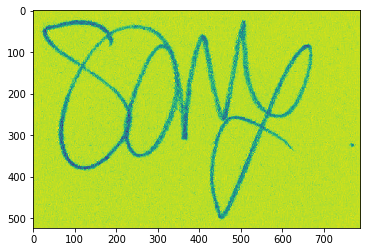

In [6]:
matplot.imshow(image)

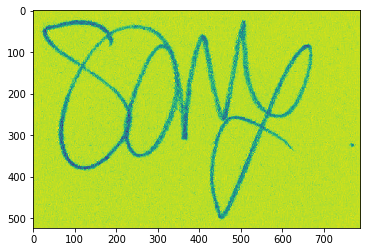

In [8]:
c = crop_image(image)
matplot.imshow(c)

In [9]:
d = thinning(c)

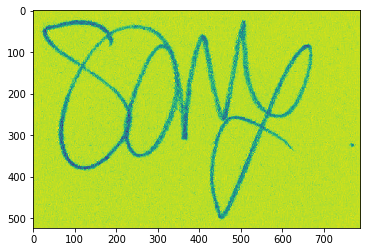

In [10]:
matplot.imshow(c)

In [15]:
area=cv2.countNonZero(d)

In [13]:
area

2417

In [16]:
crop_image

<function __main__.crop_image>

In [17]:
image

array([[242, 239, 236, ..., 238, 238, 239],
       [241, 239, 237, ..., 238, 239, 240],
       [240, 239, 238, ..., 240, 240, 241],
       ...,
       [239, 239, 239, ..., 237, 238, 238],
       [239, 239, 239, ..., 237, 238, 238],
       [239, 239, 239, ..., 237, 238, 238]], dtype=uint8)